In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import csv
import re
from collections import namedtuple
import json


import warnings
warnings.filterwarnings("ignore")

In [2]:
N_WAVELENGTH = 228
LOD_URE = 1000

In [3]:
df = pd.read_csv("data_NIRS/Merged_db.csv")
df = df.drop_duplicates()
df_copy = df.copy()
df.head()

,Mã NIR,Urea,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,Phương pháp đo,...,230,231,232,233,234,235,236,237,238,239
0,2113099a1,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",1,Hadamard 1,...,-0.136101,-0.287185,-0.380416,-0.459176,-0.407652,-0.472400,-0.429911,-0.333819,-0.395731,-0.167501
1,2113099a2,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",2,Hadamard 1,...,-0.135012,-0.306666,-0.467668,-0.492477,-0.481871,-0.370628,-0.297349,-0.409274,-0.486664,-0.426964
2,2113099a3,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",3,Hadamard 1,...,-0.324308,-0.427586,-0.539696,-0.547557,-0.575114,-0.555003,-0.462344,-0.440240,-0.298107,-0.313747
3,2113099a4,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",4,Hadamard 1,...,-0.298622,-0.377505,-0.534373,-0.577949,-0.533663,-0.570596,-0.488621,-0.419825,-0.354021,-0.295377
4,2113099a5,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",5,Hadamard 1,...,-0.272732,-0.429970,-0.496265,-0.559068,-0.586745,-0.516311,-0.469121,-0.351306,-0.360435,-0.257529


In [4]:
for type in df['Loại cá'].unique():
    sub_df = df[df['Loại cá'] == type]
    sub_labels = np.where(sub_df['Urea'] >= LOD_URE, 1, 0)
    print(type, len(sub_df['STT mẫu cá'].value_counts()), np.unique(sub_labels, return_counts=True))

Nục 1 6 (array([1]), array([360], dtype=int64))
Nục 2 57 (array([0, 1]), array([2405, 1020], dtype=int64))
Ngừ 1 52 (array([0, 1]), array([2760,  360], dtype=int64))
Thu 1 26 (array([0, 1]), array([1185,  360], dtype=int64))


# Xử lý dữ liệu NaN và vô hạn

In [5]:
print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống trước xử lý: 0
Tổng các điểm dữ liệu vô hạn trước xử lý: 0


In [6]:
# Lấy tất cả vị trí của các trị trống hoặc vô hạn
null_check = df.isna()
indices_null = np.argwhere(null_check.to_numpy() == True)

df_inf = df.iloc[:,-N_WAVELENGTH:]
inf_check = np.isinf(df_inf)
indices_inf = np.argwhere(inf_check.to_numpy()== True)
indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

indices = np.concatenate((indices_inf, indices_null))

In [7]:
n_nearest = 2 # Sử dụng n giá trị gần nhất cả 2 phía trước và sau để tính mean của missing data
for x,y in indices:
    if y < df.shape[1] - N_WAVELENGTH: # Chỉ xử lý các missing data của phổ
        continue
    #sample = df.iloc[x, np.maximum(y - n_nearest , 0):np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
    right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    sample = left.combine_first(right)
    df.iloc[x, y] = np.mean(sample)


In [8]:
print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


# Sửa các mã NIR bị lỗi 
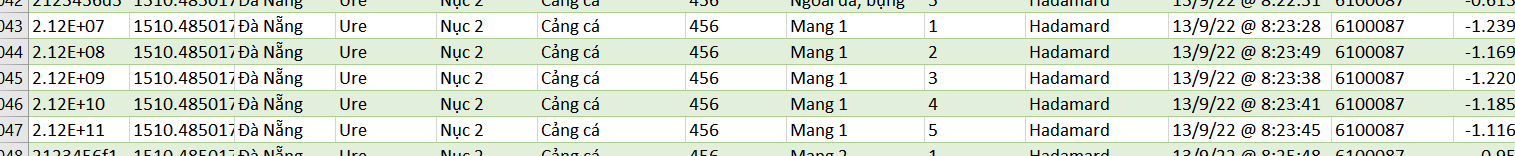

In [9]:

configJsonLink = 'config.json'
config = json.load(open(configJsonLink, encoding="utf8"))
config = namedtuple("ObjectName", config.keys())(*config.values())

nirsMetadataCoding = json.load(open(config.nirsMetadataCodingFileName, encoding="utf8"))
nirsMetadataCoding = namedtuple("ObjectName", nirsMetadataCoding.keys())(*nirsMetadataCoding.values())

In [10]:
count = 0
for i in df.index:
    nir_code = df['Mã NIR'][i]
    if not bool(re.search(r'[a-z]',nir_code)):
        nir_code_fixed = ''
        for nirsIdComponent in config.nirsIdComponents:
            nirsMetadata = [data for data in nirsMetadataCoding.nirsIdComponents if data['name'] == nirsIdComponent['name']][0]
            
            for value in nirsMetadata['decode']:
                name = nirsIdComponent['name']
                if (df[name][i] == value['name']):
                    if name == 'STT mẫu cá':
                        nir_code_fixed += str(value['key']).zfill(3)
                    else:
                        nir_code_fixed += str(value['key'])
                        
        print(f'{i} : {nir_code} ==> {nir_code_fixed}')
        df['Mã NIR'][i] = nir_code_fixed
        count +=1
        
print('samples replaced: ', count)

20 : 2.11E+07 ==> 2113099er1
21 : 2.11E+08 ==> 2113099er2
22 : 2.11E+09 ==> 2113099er3
23 : 2.11E+10 ==> 2113099er4
24 : 2.11E+11 ==> 2113099er5
80 : 2.11E+07 ==> 2113100er1
81 : 2.11E+08 ==> 2113100er2
82 : 2.11E+09 ==> 2113100er3
83 : 2.11E+10 ==> 2113100er4
84 : 2.11E+11 ==> 2113100er5
140 : 2.11E+07 ==> 2113101er1
141 : 2.11E+08 ==> 2113101er2
142 : 2.11E+09 ==> 2113101er3
143 : 2.11E+10 ==> 2113101er4
144 : 2.11E+11 ==> 2113101er5
200 : 2.11E+07 ==> 2113113er1
201 : 2.11E+08 ==> 2113113er2
202 : 2.11E+09 ==> 2113113er3
203 : 2.11E+10 ==> 2113113er4
204 : 2.11E+11 ==> 2113113er5
260 : 2.11E+07 ==> 2113114er1
261 : 2.11E+08 ==> 2113114er2
262 : 2.11E+09 ==> 2113114er3
263 : 2.11E+10 ==> 2113114er4
264 : 2.11E+11 ==> 2113114er5
320 : 2.11E+07 ==> 2113115er1
321 : 2.11E+08 ==> 2113115er2
322 : 2.11E+09 ==> 2113115er3
323 : 2.11E+10 ==> 2113115er4
324 : 2.11E+11 ==> 2113115er5
380 : 2.12E+07 ==> 2123188er1
381 : 2.12E+08 ==> 2123188er2
382 : 2.12E+09 ==> 2123188er3
383 : 2.12E+10 ==> 2

442 : 2.12E+09 ==> 2123189er3
443 : 2.12E+10 ==> 2123189er4
444 : 2.12E+11 ==> 2123189er5
500 : 2.12E+07 ==> 2123190er1
501 : 2.12E+08 ==> 2123190er2
502 : 2.12E+09 ==> 2123190er3
503 : 2.12E+10 ==> 2123190er4
504 : 2.12E+11 ==> 2123190er5
560 : 2.12E+07 ==> 2123191er1
561 : 2.12E+08 ==> 2123191er2
562 : 2.12E+09 ==> 2123191er3
563 : 2.12E+10 ==> 2123191er4
564 : 2.12E+11 ==> 2123191er5
620 : 2.12E+07 ==> 2123192er1
621 : 2.12E+08 ==> 2123192er2
622 : 2.12E+09 ==> 2123192er3
623 : 2.12E+10 ==> 2123192er4
624 : 2.12E+11 ==> 2123192er5
680 : 2.12E+07 ==> 2123193er1
681 : 2.12E+08 ==> 2123193er2
682 : 2.12E+09 ==> 2123193er3
683 : 2.12E+10 ==> 2123193er4
684 : 2.12E+11 ==> 2123193er5
740 : 2.12E+07 ==> 2123194er1
741 : 2.12E+08 ==> 2123194er2
742 : 2.12E+09 ==> 2123194er3
743 : 2.12E+10 ==> 2123194er4
744 : 2.12E+11 ==> 2123194er5
800 : 2.12E+07 ==> 2123195er1
801 : 2.12E+08 ==> 2123195er2
802 : 2.12E+09 ==> 2123195er3
803 : 2.12E+10 ==> 2123195er4
804 : 2.12E+11 ==> 2123195er5
860 : 2.12

# Tạo test data từ dữ liệu gốc, tất cả các mẫu NIR của 1 con cá (thường là 60) thì sẽ nằm trong test data

In [10]:
TEST_SIZE = 0.2

fish_numbers = df['STT mẫu cá'].unique()

ure_value = []
for number in fish_numbers:
    sub_df = df[df['STT mẫu cá'] == number]
    # print(stt, sub_df['Urea'].value_counts())
    ure_value.append(sub_df['Urea'].iloc[1])
y_labels = np.where(np.array(ure_value) >= LOD_URE, 1, 0)

number_test_fish = int(len(fish_numbers)*TEST_SIZE)

indices_below_LOD = np.where(y_labels == 0)[0]
test_indices_below_LOD = np.random.choice(indices_below_LOD, size=number_test_fish//2, replace=False)
test_fish_numbers_below_LOD = fish_numbers[test_indices_below_LOD]

indices_above_LOD = np.where(y_labels == 1)[0]
test_indices_above_LOD = np.random.choice(indices_above_LOD, size=number_test_fish//2, replace=False)
test_fish_numbers_above_LOD = fish_numbers[test_indices_above_LOD]

test_fish_number = np.hstack((test_fish_numbers_above_LOD, test_fish_numbers_below_LOD))

test_data = pd.DataFrame()
train_data = df.copy()
for i in test_fish_number:
    sub_df = df[df['STT mẫu cá'] == i]
    test_data = pd.concat([test_data, sub_df], axis=0)
    
    train_data = train_data.drop(train_data[train_data['STT mẫu cá'] == i].index)

In [ ]:
train_data.to_csv('train_data_Ure.csv', encoding='utf-8', index=False)
test_data.to_csv('test_data_Ure.csv', encoding='utf-8', index=False)

# Tiền xử lý

Savizky-Golay 

In [15]:
def my_SG(X, deriv=0):
    return savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)

# Chuẩn hóa

In [16]:
def snv(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T
    # for i in range(df_input.shape[0]):
    #     df_input.iloc[i,:] -= df_input.iloc[i,:].mean()
 
    # Ước tính phổ tham chiếu (reference spectrum) = mean
    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


# Trực quan chi tiết

Text(0.5, 1.0, 'Phổ của 5 khoảng thời gian đo của mẫu cá 041')

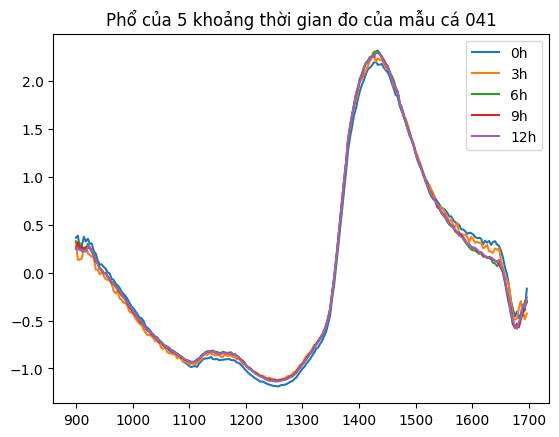

In [17]:
wl = np.arange(900, 1700, 800/228)
one_sample = df.iloc[0:5, -228:]
for i in range(5):
    plt.plot(wl, one_sample.iloc[i,:], label=f'{i*3}h')
plt.legend()
plt.title('Phổ của 5 khoảng thời gian đo của mẫu cá 041')

In [16]:
(1.2 + 0.87 + 0.6 + 1.13)/4

0.95

In [18]:
sample = []
for type in df['Loại cá'].unique():
    c = df[df['Loại cá'].str.contains(type)].reset_index()
    sample.append(c.iloc[0,-228:].to_numpy())
    
X_sample = pd.DataFrame(sample)
wl = np.arange(900, 1700, 800/228)

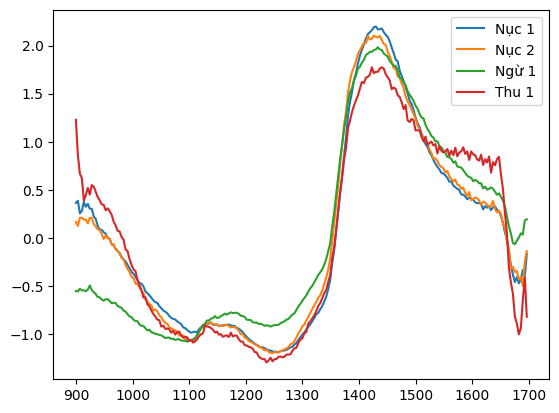

In [19]:
for i, type_fiss in enumerate(df['Loại cá'].unique()):
    plt.plot(wl, (X_sample).iloc[i,:], label=type_fiss)
plt.legend()

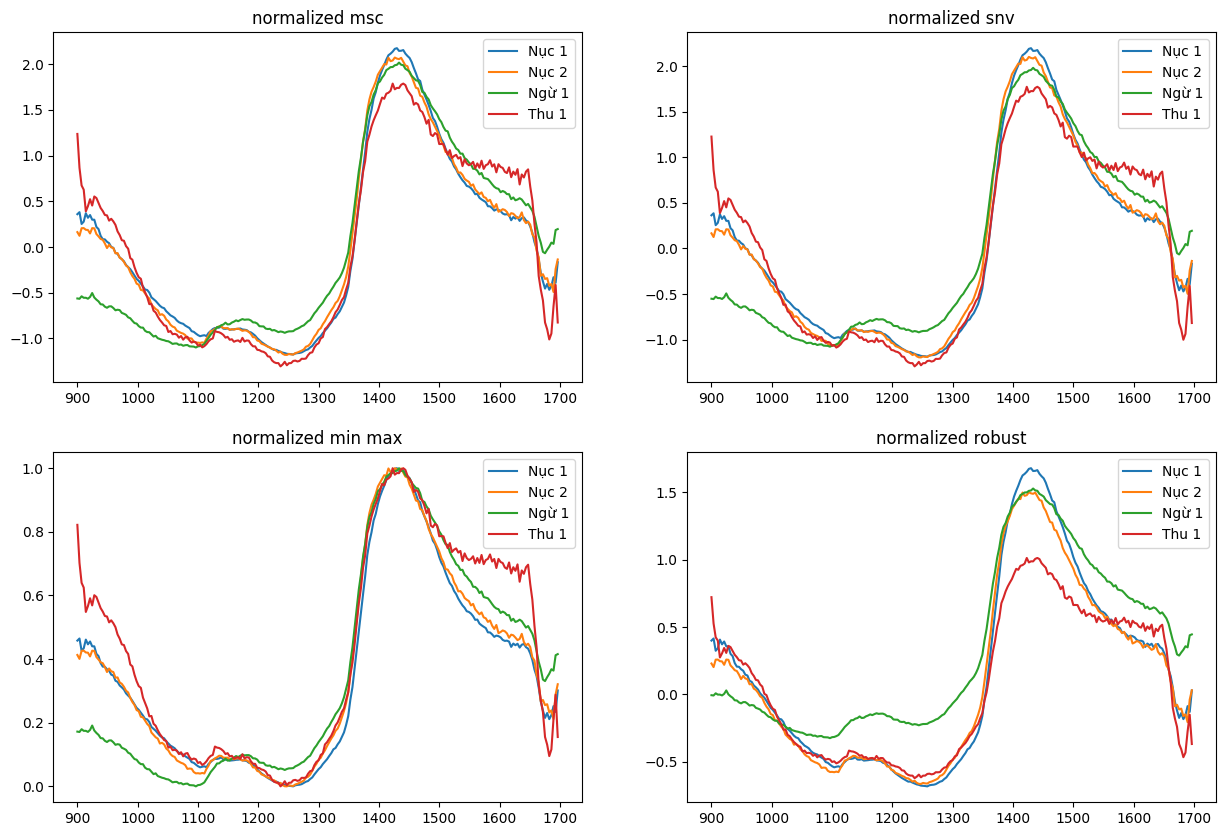

In [20]:
X_Robust = my_RobustScaler(X_sample)
X_minmax = my_MinMaxScaler(X_sample)
X_msc = msc(X_sample)
X_snv = snv(X_sample)

my_list = [X_msc, X_snv, X_minmax, X_Robust]
name = ['normalized msc', 'normalized snv', 'normalized min max', 'normalized robust']

fig, ax = plt.subplots(2, 2, figsize=(15,10))

i2 = 0
for a in range(2):
    for b in range(2):
        for i, type_fiss in enumerate(df['Loại cá'].unique()):
            ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
            ax[a][b].set_title(name[i2])
        ax[a][b].legend()
        i2 += 1

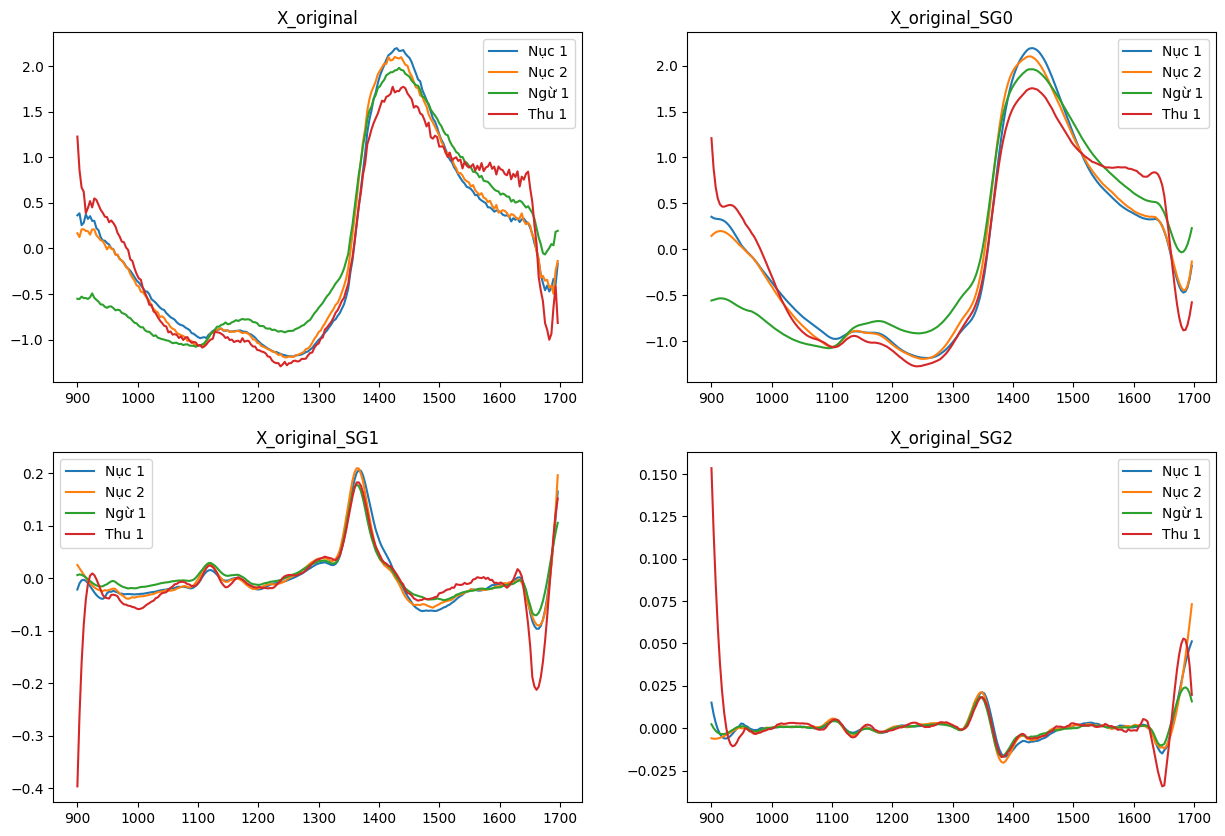

In [21]:
def plot_spectral(data, name_data):
    fig, ax = plt.subplots(2, 2, figsize=(15,10))

    X_SG0 = pd.DataFrame(my_SG(data, deriv=0))
    X_SG1 = pd.DataFrame(my_SG(data, deriv=1))
    X_SG2 = pd.DataFrame(my_SG(data, deriv=2))

    my_list = [data, X_SG0, X_SG1, X_SG2 ]
    name = [f'X_{name_data}', f'X_{name_data}_SG0', f'X_{name_data}_SG1', f'X_{name_data}_SG2']

    wl = np.arange(900, 1700, 800/228)
    i2 =0
    for a in range(2):
        for b in range(2):
            for i, type_fiss in enumerate(df['Loại cá'].unique()):
                ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
                ax[a][b].set_title(name[i2])
            ax[a][b].legend()
            i2 += 1
        
plot_spectral(X_sample, 'original')

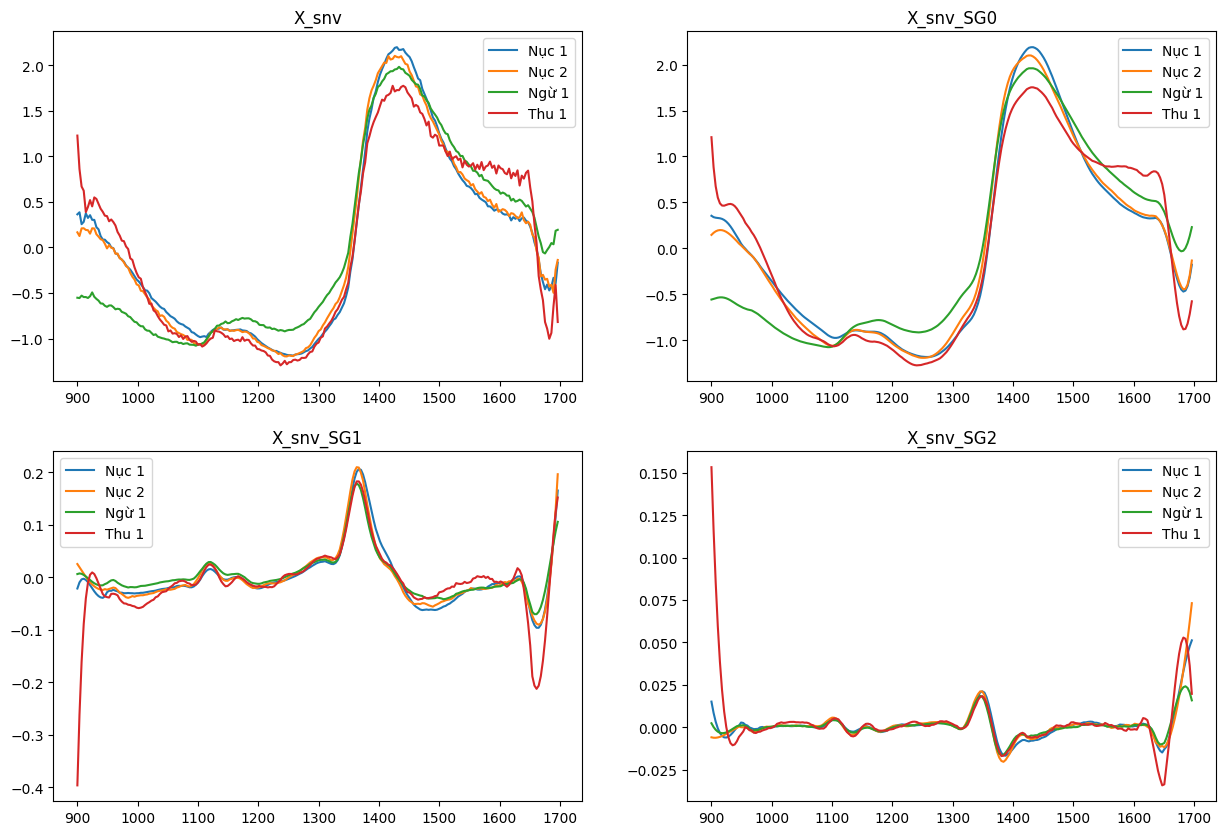

In [23]:
plot_spectral(X_snv, 'snv')

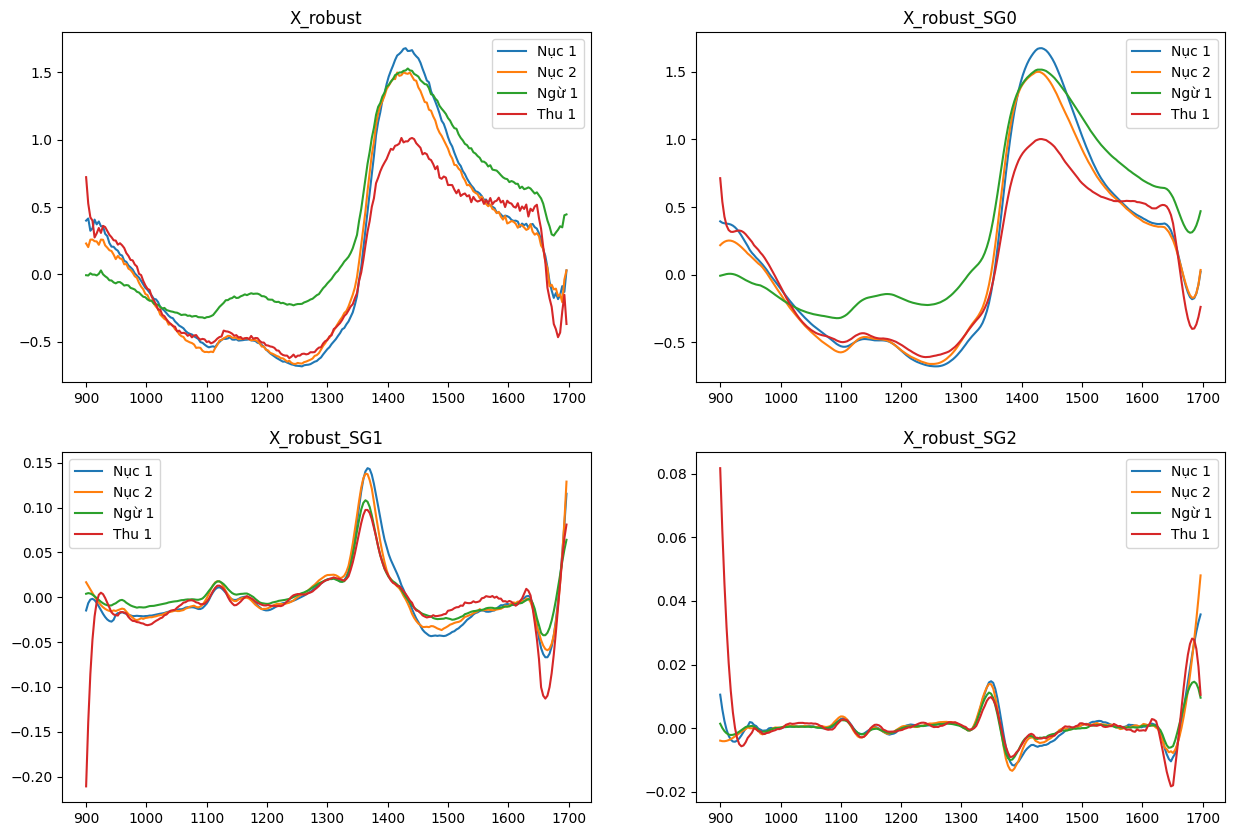

In [24]:
plot_spectral(X_Robust, 'robust')

In [80]:
train_data['Loại cá'].unique(), test_data['Loại cá'].unique()

(array(['Nục 1', 'Nục 2', 'Ngừ 1', 'Thu 1'], dtype=object),
 array(['Ngừ 1', 'Nục 1', 'Nục 2', 'Thu 1'], dtype=object))

In [81]:
sample_train = []
sample_test = []
for type in train_data['Loại cá'].unique():
    c = train_data[train_data['Loại cá'].str.contains(type)].reset_index()
    sample_train.append(c.iloc[0,-228:].to_numpy())

for type in test_data['Loại cá'].unique():
    c = test_data[test_data['Loại cá'].str.contains(type)].reset_index()
    sample_test.append(c.iloc[0,-228:].to_numpy())
    
X_sample_train = pd.DataFrame(sample_train)
X_sample_test = pd.DataFrame(sample_test)

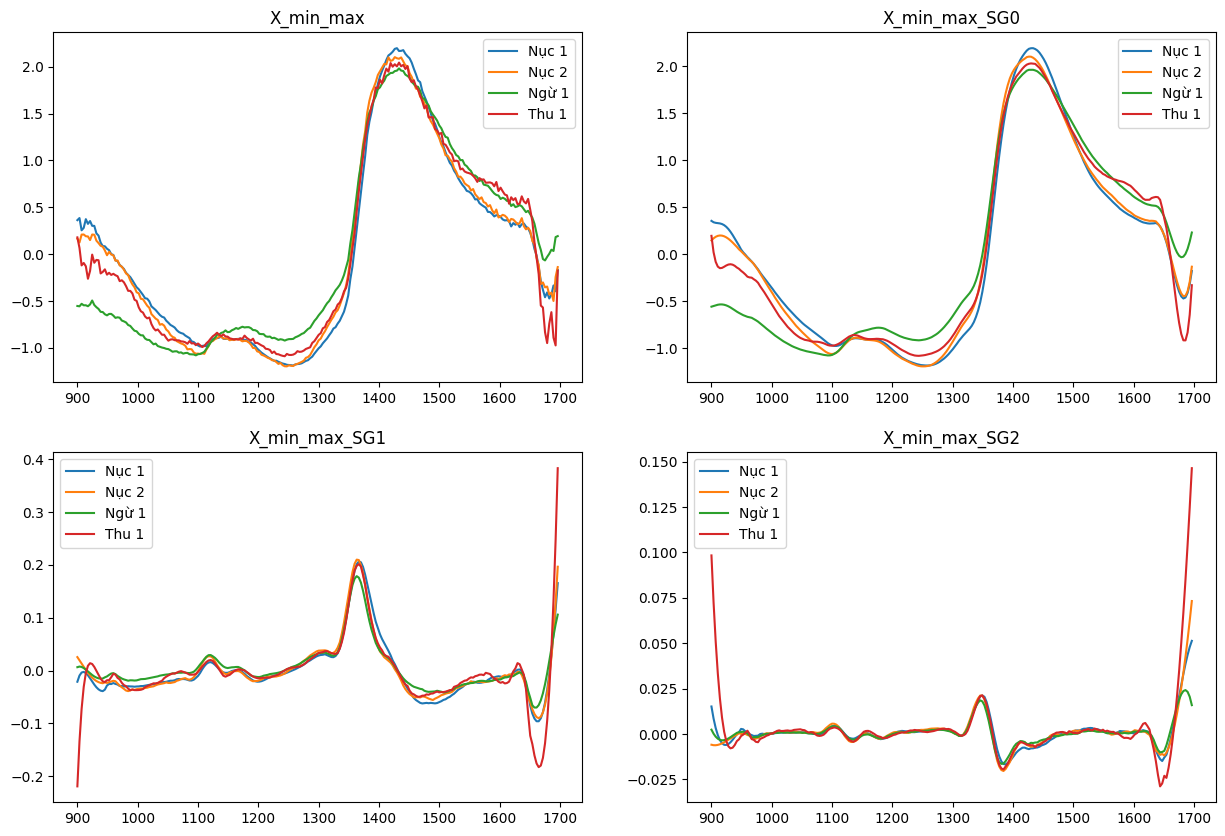

In [82]:
plot_spectral(X_sample_train, 'min_max')

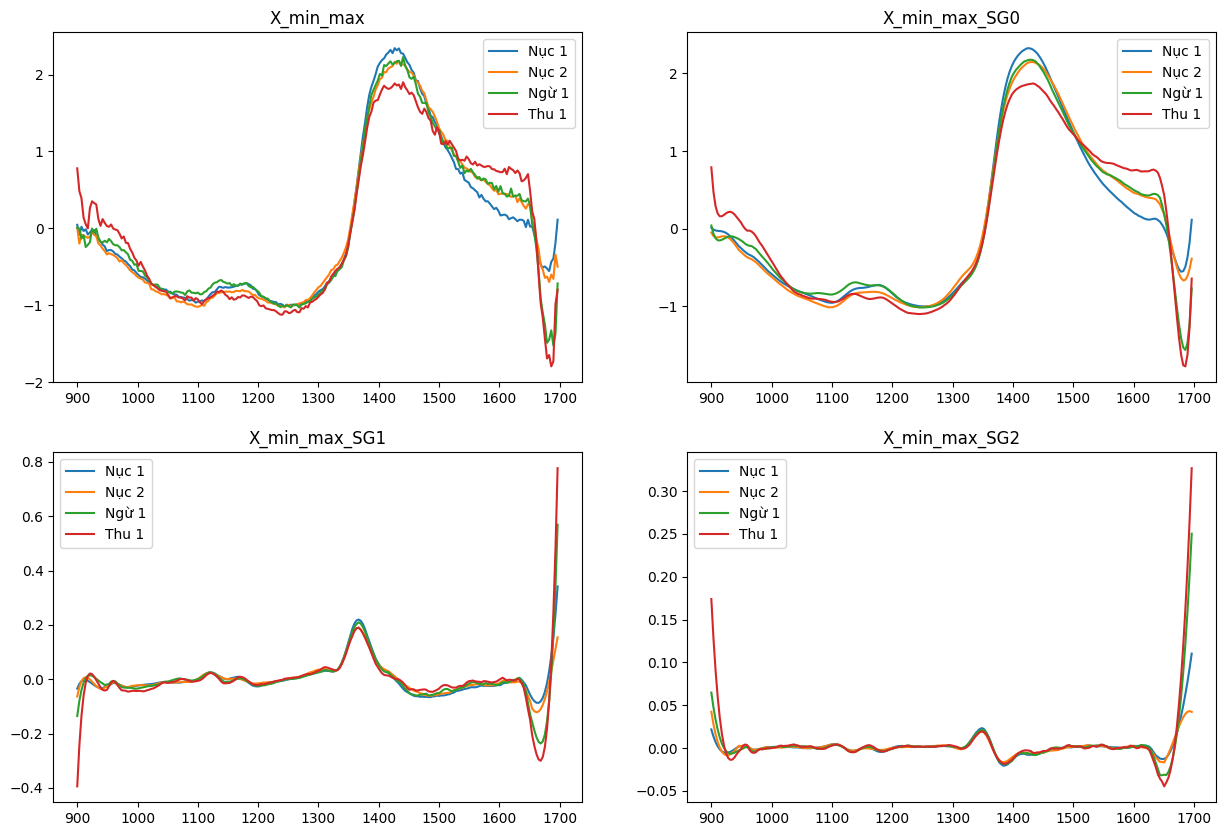

In [85]:
plot_spectral(snv(X_sample_test), 'min_max')